<small><i>This notebook was put together by [Wesley Beckner](http://wesleybeckner.github.io/).</i></small>

In [2]:
import cv2
import numpy as np
import scipy.io
import scipy.optimize
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import pandas
#import magni
import math
from PIL import Image
#import seaborn as sns; sns.set()
from sklearn.cross_validation import train_test_split

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

def myround(x, base):
    return (float(base) * round(float(x)/float(base)))

params = {
    'lines.markersize' : 3,
    'axes.labelsize': 20,
    'font.size': 20,
    'legend.fontsize': 10,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'text.usetex': False,
    
   }


#plp.rcParams.update(params)
plt.rcParams.update(params)

In [5]:
import sys
sys.platform

'darwin'

<a id='top'></a>

# AFM MINER

Note: you can follow install instructions for CV, the image analysis toolkit, [here](http://www.pyimagesearch.com/2015/06/22/install-opencv-3-0-and-python-2-7-on-ubuntu/)

* Wes had trouble with one of the dependencies, specifically: `sudo apt-get install libgtk2.0-dev` which may lead to trouble with displaying images to the screen

## Project Design Outline

AfmMiner uses **Random Forests**, a kind of non-parametric supervised learning algorithm, to discover materials properties from atomic force microscopy (AFM) images. In particular, afmMiner can predict the photoluminesence of a material given some topographical and electrical AFM data. AfmMiner addresses a fundamental question: **can we predict PL from things that are not difraction limited?**.

The software uses a *double sweep* method, a kind of image analysis first used in telescopic image processing, to refine the clarity for high luminescent regions of the material. To do this, the program will go through the image and characterize the low luminescent regions. Then, the program will go through image and characterize the high luminescent region with a regression attuned to the high luminescence regions.

We will implement an 'auto-alignment' procedure to ensure the images are the same and can be laid on top of each other for more accurate predictions of photoluminescence. There will also be an alignment score to describe how close to aligned each of the images are to each other and determine how accurate the prediction is. This algorithm will look at the topography file that is outputted from the AFM during each test to align the images.

We plan on implementing a GUI/functionality interface for easy manipulation and visualization of the process. The parameters that a user could manipulate include the number of trees, depth of each tree, input images, parameter that adjusts 'double sweep' method (i.e. photoluminescence cutoff) and the size of array for the algorithm to draw extra data from. We will include a wrapper function that iterates through many different tree numbers, tree depths, surrounding array size and double sweep parameter to output the 'optimal' set. Some of the outputs from this would be the accuracy of the predictions to the actual photoluminescence, visualization of random tree structure, optimal set of parameters, and the predicted vs. actual photoluminescence images.

The data will be images that have been collected with various atomic force microscopy (AFM) techniques. They include scanning kelvin probe microscopy (SKPM), photoconducdtive atomic force microscopy (pc-AFM), and photoluminesence (PL). In each technique, an AFM probe raster scans an area of a sample to produce a topography image. The probe then raster scans the same area again, retracing the topography obtained from the first pass, and while doing so, probes some nanoscale, electrical property of the sample area. SKPM probes the relative contact difference potential between the tip and sample. In pc-AFM, a bias is applied at each point and the current measured; a current-voltage curve can at each point can be constructed to obtain the open circuit voltage. The PL image is not collected with an AFM tip; it is an optical measurement in which a sample is excited by a laser beam. Photons emitted by a generate a current through a photomultiplier tube, which produces a PL map. PL is a diffraction limited technique and therefore has resolution lower than that of AFM-based techniques.

Each image is constructed from a 256X256 array. Except for PL, there is a corresponding topography image. The data has been provided by the Ginger Lab.

Since we have the corresponding PL image for the data, we can divide an image into two halves, one of which is used to train the model and the other which can be used to test the model.


## Directory 

[The functions](#functions)

[Load and visualize data](#visualize)

[Single pixel feature vector](#single)

[Double scan approach](#double)

[Some notes](#notes)

<a id='functions'></a>
# Functions

In [1]:
def myround(x, base):
    return (float(base) * round(float(x)/float(base)))

In [2]:
def selfCompare(x_input, y_input, n_trees=5, n_depth=5, n_feature_vector=1):
    """
    selfCompare

    selfCompare will train an random forrest on the top half of a set of input images 
    and use the bottom half to make a prediction of the photoluminescence of the same
    material. 

    selfCompare(n_trees, n_depth, n_feature_vector, x_input, y_input)

    n_trees: default 5

    n_depth: default 5

    n_feature_vector: default 1
        can be 1, 2, or 3 surrounding pixels

    x_input: no default, tuple of file names

    y_input: no default, file name
    """
    ###import modules
    import numpy as np
    from sklearn import metrics
    from sklearn.ensemble import RandomForestRegressor
    import matplotlib.pyplot as plt
    
    
    ###User specified parameters
    inputs=np.zeros(len(x_input), dtype=object)
    Pl=np.loadtxt('../data/%s.txt' % y_input,skiprows=0, dtype=np.float64)

    x9x9 = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    x7x7 = [-3, -2, -1, 0, 1, 2, 3]
    x5x5 = [-2, -1, 0, 1, 2]
    x3x3 = [-1, 0, 1]

    pixel_handles = [x3x3, x5x5, x7x7, x9x9]
    
    depths = n_depth
    trees = n_trees

    for h,i in enumerate(x_input):
        inputs[h] = np.loadtxt('../data/%s.txt' % i,skiprows=0, dtype=np.float64)

    ###Create training and testing arrays
    x = int(inputs[0].shape[0]/2)
    x2 = inputs[0].shape[0]
    y = inputs[0].shape[1]

 
    pixelContext = pixel_handles[n_feature_vector-1]
    Xtrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0

    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                
                for l in pixelContext:
                    for m in pixelContext:
                        Xtrain[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Xtest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtest[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Ytrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0 
    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytrain[k]=Pl[p,q]
            k = k + 1

    Ytest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytest[k]=Pl[p,q]
            k = k + 1

    ###Run Algorithm
    k=0
    prediction = []

    clf = RandomForestRegressor(max_depth=depths, n_estimators=trees, bootstrap=True)
    clf.fit(Xtrain, Ytrain)
    hold = clf.predict(Xtest)
    score = metrics.mean_squared_error(Ytest, hold)
    roundscore = myround(score, 0.001)

    prediction.append(hold)
    k = k + 1

    k=0
    merge = (np.array(prediction).flatten())
    Pl_predict = np.zeros(((x-max(pixelContext))*1,(y-(max(pixelContext)*2))*1))
    for l in range(1):
        for i in range((x-max(pixelContext))*1):
            for j in range (y-(max(pixelContext)*2)):
                Pl_predict[i,j+(l*(y-(max(pixelContext)*2)))] = merge[k]
                k = k + 1
    
    fig = plt.figure(figsize=(10,10))
    
    pl_ax = fig.add_subplot(121)
    pl_ax.imshow(Pl_predict.T, cmap='viridis')
    pl_ax.text(-10,275,'%s x %s Feature Vector, %s depth, %s trees; score: %s' %(n_feature_vector,n_feature_vector,n_depth,\
        n_trees,roundscore), size=24)
    pl_ax.axes.get_xaxis().set_ticks([])
    pl_ax.axes.get_yaxis().set_ticks([])
    pl_ax.set_title('Prediction', size=30)
   
    pl_ax2 = fig.add_subplot(122)
    pl_ax2.set_title('Actual', size=30)
    pl_ax2.imshow(Pl[Pl.shape[0]/2:,:].T, cmap='viridis')
    pl_ax2.axes.get_xaxis().set_ticks([])
    pl_ax2.axes.get_yaxis().set_ticks([])
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,\
                        wspace=None, hspace=None)
    return clf
    plt.show()
    #fig.savefig(filename='vector_variation_MABr', bbox_inches='tight')

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

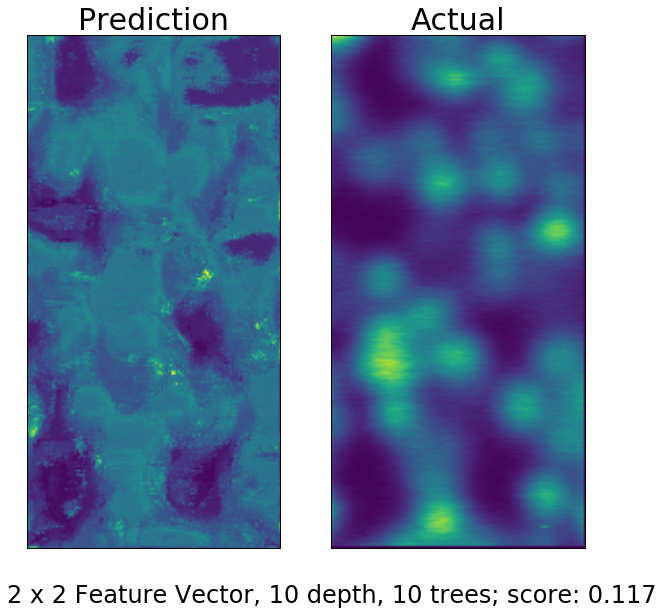

In [11]:
selfCompare(['MABr.1.Ht', 'MABr.1.Po', 'MABr.1.Ph', 'MABr.1.Am'], 'MABr.1.Pl',n_feature_vector=2, n_trees=10, n_depth=10)

In [3]:
def crossCompare(x_input1, y_input1, x_input2, y_input2, n_trees=5, n_depth=5, n_feature_vector=1):
    """
    crossCompare

    crossCompare trains a random forrest on the top half of a set of input images 
    and uses the bottom half to make a prediction of the photoluminescence of the same
    material. 

    crossCompare(n_trees, n_depth, n_feature_vector, x_input, y_input)

    n_trees: default 5

    n_depth: default 5

    n_feature_vector: default 1
        can be 1, 2, or 3 surrounding pixels

    x_input: no default, tuple of file names

    y_input: no default, file name
    """
    my_model = selfCompare(x_input1, y_input1, n_trees=n_trees, n_depth=n_depth, n_feature_vector=n_feature_vector)
    ###import modules
    import numpy as np
    
    
    ###User specified parameters
    inputs=np.zeros(len(x_input2), dtype=object)
    Pl=np.loadtxt('../data/%s.txt' % y_input2,skiprows=0, dtype=np.float64)

    x9x9 = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    x7x7 = [-3, -2, -1, 0, 1, 2, 3]
    x5x5 = [-2, -1, 0, 1, 2]
    x3x3 = [-1, 0, 1]

    pixel_handles = [x3x3, x5x5, x7x7, x9x9]
    
    depths = n_depth
    trees = n_trees

    for h,i in enumerate(x_input2):
        inputs[h] = np.loadtxt('../data/%s.txt' % i,skiprows=0, dtype=np.float64)
        
    ###Create training and testing arrays
    x = int(inputs[0].shape[0]/2)
    x2 = inputs[0].shape[0]
    y = inputs[0].shape[1]

 
    pixelContext = pixel_handles[n_feature_vector-1]

    Xtest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtest[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1


    Ytest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytest[k]=Pl[p,q]
            k = k + 1

    prediction = []
    hold = my_model.predict(Xtest)
    score = metrics.mean_squared_error(Ytest, hold)
    roundscore = myround(score, 0.001)
    prediction.append(hold)
    k=0
    merge = (np.array(prediction).flatten())
    Pl_predict = np.zeros(((x-max(pixelContext))*1,(y-(max(pixelContext)*2))*1))
    for l in range(1):
        for i in range((x-max(pixelContext))*1):
            for j in range (y-(max(pixelContext)*2)):
                Pl_predict[i,j+(l*(y-(max(pixelContext)*2)))] = merge[k]
                k = k + 1

    fig = plt.figure(figsize=(10,10))

    pl_ax = fig.add_subplot(121)
    pl_ax.imshow(Pl_predict.T, cmap='viridis')
    #pl_ax.text(-10,275,'%s x %s Feature Vector, %s depth, %s trees; score: %s' %(n_feature_vector,n_feature_vector,n_depth,\
    #    n_trees,roundscore), size=24)
    pl_ax.axes.get_xaxis().set_ticks([])
    pl_ax.axes.get_yaxis().set_ticks([])
    pl_ax.set_title('Prediction', size=30)

    pl_ax2 = fig.add_subplot(122)
    pl_ax2.set_title('Actual', size=30)
    pl_ax2.imshow(Pl[Pl.shape[0]/2:,:].T, cmap='viridis')
    pl_ax2.axes.get_xaxis().set_ticks([])
    pl_ax2.axes.get_yaxis().set_ticks([])
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,\
                        wspace=None, hspace=None)
    
    plt.show()

In [21]:
x_input1=['MABr.1.Ht', 'MABr.1.Po', 'MABr.1.Ph', 'MABr.1.Am']
y_input1='MABr.1.Pl'
x_input2=['Ht', 'Po', 'Ph', 'Am']
y_input2='Pl'

crossCompare(x_input1, y_input1, x_input2, y_input2)

In [4]:
def afmSetup(x_input, y_input, n_trees=5, n_depth=5, n_feature_vector=1):

    ###Setup user defined variables
    x9x9 = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    x7x7 = [-3, -2, -1, 0, 1, 2, 3]
    x5x5 = [-2, -1, 0, 1, 2]
    x3x3 = [-1, 0, 1]
    pixel_handles = [x3x3, x5x5, x7x7, x9x9]    
    pixelContext = pixel_handles[n_feature_vector-1]   
    depths = n_depth
    trees = n_trees
    return pixelContext, depths, trees

In [1]:
def afmTrainTest(x_input, y_input, pixelContext, depths, trees, train, test):
    """

    selfCompare will train an random forrest on the top half of a set of input images 
    and use the bottom half to make a prediction of the photoluminescence of the same
    material. 

    selfCompare(n_trees, n_depth, n_feature_vector, x_input, y_input)

    n_trees: default 5

    n_depth: default 5

    n_feature_vector: default 1
        can be 1, 2, or 3 surrounding pixels

    x_input: no default, tuple of file names

    y_input: no default, file name
    """
    ###import modules
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn import preprocessing
    
    ###Load data and scale
    inputs=np.zeros(len(x_input), dtype=object)

    Pl=preprocessing.scale(np.loadtxt('../data/%s.txt' % y_input,skiprows=0, dtype=np.float64))
    
    for h,i in enumerate(x_input):
        
        inputs[h] = preprocessing.scale(np.loadtxt('../data/%s.txt' % i,skiprows=0, dtype=np.float64))
        
    
    
    ###Decide how to parse inputs (train+test, train, or test)   
    y = inputs[0].shape[1]
#     if train==True & test==True:
#         x = int(inputs[0].shape[0]/2)
#         x2 = inputs[0].shape[0]
#     elif train==True:
#         x = inputs[0].shape[0]
#     else:
#         x = max(pixelContext)
#         x2 = inputs[0].shape[0]
    x = int(inputs[0].shape[0]/2)
    x2 = inputs[0].shape[0]
    ###Create training and testing arrays
    if train==True:
        Xtrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),\
                 (len(pixelContext)*len(pixelContext)*len(inputs))))
        k=0
        for p in range(max(pixelContext),x):
            for q in range(max(pixelContext),y-max(pixelContext)):
                j=0
                for h, i in enumerate(inputs):

                    for l in pixelContext:
                        for m in pixelContext:
                            Xtrain[k,j]=i[(p+l),(q+m)]
                            j=j+1
                k = k + 1
        Ytrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
        k=0 
        for p in range(max(pixelContext),x):
            for q in range(max(pixelContext),y-max(pixelContext)):
                Ytrain[k]=Pl[p,q]
                k = k + 1
    if test==True:
        Xtest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),\
                (len(pixelContext)*len(pixelContext)*len(inputs))))
        k=0
        for p in range(x,x2-max(pixelContext)):
            for q in range(max(pixelContext),y-max(pixelContext)):
                j=0
                for h, i in enumerate(inputs):
                    for l in pixelContext:
                        for m in pixelContext:
                            Xtest[k,j]=i[(p+l),(q+m)]
                            j=j+1
                k = k + 1

        Ytest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
        k=0
        for p in range(x,x2-max(pixelContext)):
            for q in range(max(pixelContext),y-max(pixelContext)):
                Ytest[k]=Pl[p,q]
                k = k + 1
    if train==True & test==True:
        return Xtrain, Ytrain, Xtest, Ytest, x, y, Pl
    elif train==True:
        return Xtrain, Ytrain, x, y, Pl
    else:
        return Xtest, Ytest, x, y, Pl

In [20]:
def afmModel(Xtrain, Ytrain, Xtest, Ytest, depths, trees, x, y, pixelContext, selfCompare=True):
    from sklearn import metrics
    from sklearn.ensemble import RandomForestRegressor
    import numpy as np

    k=0
    prediction = []

    clf = RandomForestRegressor(max_depth=depths, n_estimators=trees, bootstrap=True)
    clf.fit(Xtrain, Ytrain)
    hold = clf.predict(Xtest)
    score = metrics.mean_squared_error(Ytest, hold)
    roundscore = myround(score, 0.001)

    prediction.append(hold)
    k = k + 1
    
    

    k=0
    merge = (np.array(prediction).flatten())
    Pl_predict = np.zeros(((x-max(pixelContext))*1,(y-(max(pixelContext)*2))*1))
    for l in range(1):
        for i in range((x-max(pixelContext))*1):
            for j in range (y-(max(pixelContext)*2)):
                Pl_predict[i,j+(l*(y-(max(pixelContext)*2)))] = merge[k]
                k = k + 1
    return Pl_predict, clf, roundscore

In [21]:
def afmImageShow(Pl_predict, n_feature_vector, n_depth, n_trees, roundscore, Pl):
    import matplotlib.pyplot as plt       
    fig = plt.figure(figsize=(10,10))
    
    pl_ax = fig.add_subplot(121)
    pl_ax.imshow(Pl_predict.T, cmap='viridis')
    pl_ax.text(-10,275,'%s x %s Feature Vector, %s depth, %s trees; score: %s' %(n_feature_vector,n_feature_vector,n_depth,\
        n_trees,roundscore), size=24)
    pl_ax.axes.get_xaxis().set_ticks([])
    pl_ax.axes.get_yaxis().set_ticks([])
    pl_ax.set_title('Prediction', size=30)
   
    pl_ax2 = fig.add_subplot(122)
    pl_ax2.set_title('Actual', size=30)
    pl_ax2.imshow(Pl[Pl.shape[0]/2:,:].T, cmap='viridis')
    pl_ax2.axes.get_xaxis().set_ticks([])
    pl_ax2.axes.get_yaxis().set_ticks([])
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,\
                        wspace=None, hspace=None)
    
    plt.show()

In [22]:
def testSelf(x_input, y_input, n_trees=5, n_depth=5, n_feature_vector=1):
    ###import modules
    import numpy as np
    from sklearn import metrics
    from sklearn.ensemble import RandomForestRegressor
    import matplotlib.pyplot as plt
    pixelContext, depths, trees = afmSetup(x_input, y_input, n_trees=5, n_depth=5, n_feature_vector=1)

    Xtrain, Ytrain, Xtest, Ytest, x, y, Pl = afmTrainTest(x_input, y_input, pixelContext, depths, trees, train=True, test=True)
    Pl_predict, clf, roundscore = afmModel(Xtrain, Ytrain, Xtest, Ytest, depths, trees, x, y, pixelContext)
    
    afmImageShow(Pl_predict, n_feature_vector, n_depth, n_trees, roundscore, Pl)

In [23]:
def testCross(x_input1, y_input1, x_input2, y_input2, n_trees=5, n_depth=5, n_feature_vector=1):
    ###import modules
    import numpy as np
    from sklearn import metrics
    from sklearn.ensemble import RandomForestRegressor
    import matplotlib.pyplot as plt
    pixelContext, depths, trees = afmSetup(x_input1, y_input1, n_trees=5, n_depth=5, n_feature_vector=1)

    Xtrain, Ytrain, x, y, Pl = afmTrainTest(x_input1, y_input1, pixelContext, depths, trees, train=True, test=False)
    Xtest, Ytest, x, y, Pl = afmTrainTest(x_input2, y_input2, pixelContext, depths, trees, train=False, test=True)
    
    Pl_predict, clf, roundscore = afmModel(Xtrain, Ytrain, Xtest, Ytest, depths, trees, x, y, pixelContext)
    
    afmImageShow(Pl_predict, n_feature_vector, n_depth, n_trees, roundscore, Pl)

In [36]:
x_input1=['MABr.1.Ht', 'MABr.1.Po', 'MABr.1.Ph', 'MABr.1.Am']
y_input1='MABr.1.Pl'
x_input2=['Ht', 'Po', 'Ph', 'Am']
y_input2='Pl'

testCross(x_input1, y_input1, x_input2, y_input2, n_trees=10, n_depth=10, n_feature_vector=3)

In [34]:
x_input1=['MABr.1.Ht', 'MABr.1.Po', 'MABr.1.Ph', 'MABr.1.Am']
y_input1='MABr.1.Pl'
x_input2=['Ht', 'Po', 'Ph', 'Am']
y_input2='Pl'

testSelf(x_input2, y_input2, n_trees=5, n_depth=5, n_feature_vector=1)

<a id='visualize'></a>
## Finding objects in the data: Using the Canny edge detector in [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html#canny)

**Edge vs region based techniques:**
* Edge detection based methods of finding objects focus on the expectation of a gradient at the object's edge and the background
* Region based methods focus on the object itself

** How the Canny edge dection algorithm works:**
1. Use a [convolution operator](http://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm) to remove noise. In this case we apply a 5x5 guassian operator/filter. 
    * The idea behind filter-based approaches to reducing noise is to consider a window of surrounding pixels and use a combination of their values to replace the current pixel.
![](../images/4.png)
![](../images/5.png)
2. Use a convolution method to find edge gradients and angles. That is, weight the discrete sum of the image with another discrete function, the spatial mask. In this case, the Sobel operator is the spatial mask. OpenCV rounds this angle as one of four directions; the gradient is always perpendicular to the edge direction
![](../images/1.png)
3. Use non-maximum suppression to turn pixel values to zero if they don't exist at a local maximum in its neighborhood in the direction of the gradient. An effective method of thinning the edge
![](../images/2.png)
4. Perform hysteresis thresholding. Rather than instatiating a cut off for gradients values, pixels greater than a max value are binned as edges, pixels less than a min value are binned as not edges, and anything between is classified as an edge it is connected to max value binned edges. 
![](../images/3.png)    

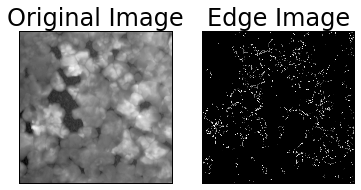

In [39]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('height.jpg',0)
#Python: cv.Canny(image, edges, threshold1, threshold2, aperture_size=3) → None
edges = cv2.Canny(img,0,17,3)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

** Cons of the edge-based method and the OpenCV Canny edge dector:**
* Success is dependent on how well the object is separated from the background (the severity of the generated pixel gradient at the edge)
* Can't adjust the gaussian filter, where there is a trade-off between size of the filter and reduction in noise. Actually, Canny had first suggested using different values of sigma and resulting edge images be integrated for the final result. Larger sigmas capture coarser details in the image.
* Can't employ other filters such as the wavelet-based approaches
    
** Pros **
* Can adjust the size of the sobel kernel, high and low pass filters

In [29]:
im = cv2.imread('messi5.jpg')
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.\
    THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_LABEL_CCOMP,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

AttributeError: 'module' object has no attribute 'connectedComponents'

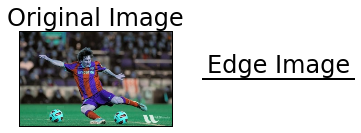

In [21]:
import numpy as np
import cv2

im = cv2.imread('messi5.jpg')
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
contours, hierarchy = cv2.findContours(thresh\
     ,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[4]
img = cv2.drawContours(imgray, [cnt], 0, (0,255,0), 3)

plt.subplot(121),plt.imshow(im,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(hierarchy,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

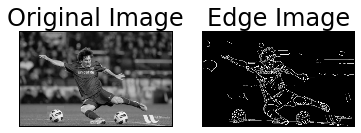

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('messi5.jpg',0)
edges = cv2.Canny(img,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

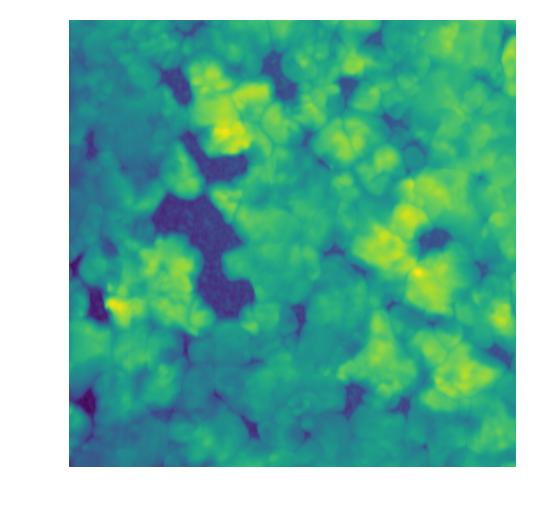

In [12]:
Ht1 = np.loadtxt('data/Ht.txt',skiprows=0, dtype=np.float64)
Po1 = np.loadtxt('data/Po.txt',skiprows=0, dtype=np.float64)
Ph1 = np.loadtxt('data/Ph.txt',skiprows=0, dtype=np.float64)
Am1 = np.loadtxt('data/Am.txt',skiprows=0, dtype=np.float64)
Pl1 = np.loadtxt('data/Pl.txt',skiprows=0, dtype=np.float64)

fig = plt.figure(figsize=(8,8))
ht_ax = fig.add_subplot(111)
# po_ax = fig.add_subplot(242)
# ph_ax = fig.add_subplot(245)
# am_ax = fig.add_subplot(246)
# pl_ax = fig.add_subplot(122)

ht_ax.imshow(Ht1, cmap='viridis')#cmap='afmhot'
# ht_ax.set_title('Height')
ht_ax.axis('off')

# po_ax.imshow(Po1, cmap='viridis')#, cmap='cubehelix'
# po_ax.set_title('Potential')
# po_ax.axis('off')

# ph_ax.imshow(Ph1, cmap='viridis')
# ph_ax.set_title('Phase')
# ph_ax.axis('off')

# am_ax.imshow(Am1, cmap='viridis')
# am_ax.set_title('Amplitude')
# am_ax.axis('off')

# pl_ax.imshow(Pl1, cmap='viridis')
# pl_ax.set_title('Photoluminescence')
# pl_ax.axis('off')

# # flatten the images
# Ht1_flat = Ht1.flatten()
# Po1_flat = Po1.flatten()
# Ph1_flat = Ph1.flatten()
# Am1_flat = Am1.flatten()
# Pl1_flat = Pl1.flatten()

fig.savefig(filename='height.jpg', dpi=300)
plt.show()

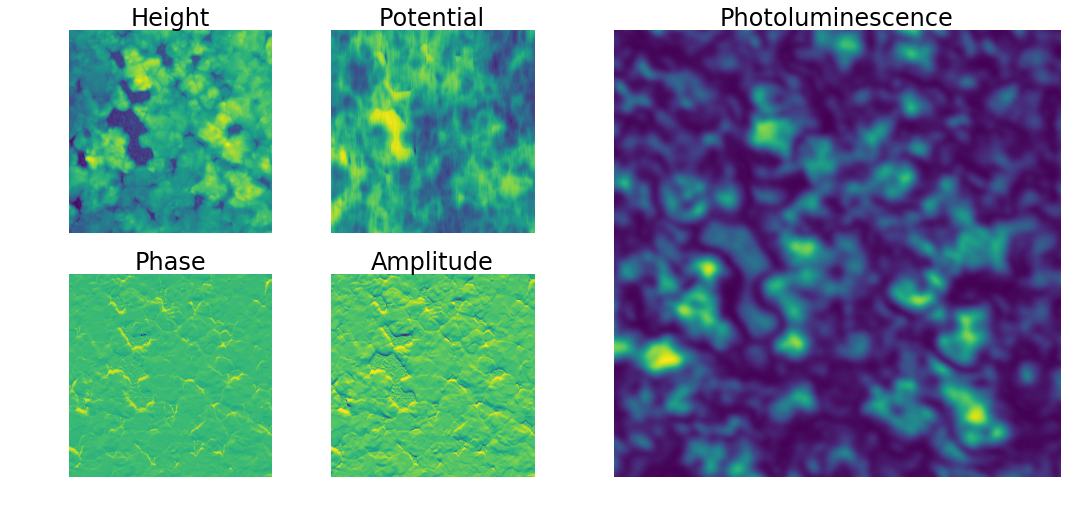

In [3]:
Ht1 = np.loadtxt('data/Ht.txt',skiprows=0, dtype=np.float64)
Po1 = np.loadtxt('data/Po.txt',skiprows=0, dtype=np.float64)
Ph1 = np.loadtxt('data/Ph.txt',skiprows=0, dtype=np.float64)
Am1 = np.loadtxt('data/Am.txt',skiprows=0, dtype=np.float64)
Pl1 = np.loadtxt('data/Pl.txt',skiprows=0, dtype=np.float64)

fig = plt.figure(figsize=(18,8))
ht_ax = fig.add_subplot(241)
po_ax = fig.add_subplot(242)
ph_ax = fig.add_subplot(245)
am_ax = fig.add_subplot(246)
pl_ax = fig.add_subplot(122)

ht_ax.imshow(Ht1, cmap='viridis')#cmap='afmhot'
ht_ax.set_title('Height')
ht_ax.axis('off')

po_ax.imshow(Po1, cmap='viridis')#, cmap='cubehelix'
po_ax.set_title('Potential')
po_ax.axis('off')

ph_ax.imshow(Ph1, cmap='viridis')
ph_ax.set_title('Phase')
ph_ax.axis('off')

am_ax.imshow(Am1, cmap='viridis')
am_ax.set_title('Amplitude')
am_ax.axis('off')

pl_ax.imshow(Pl1, cmap='viridis')
pl_ax.set_title('Photoluminescence')
pl_ax.axis('off')

# flatten the images
Ht1_flat = Ht1.flatten()
Po1_flat = Po1.flatten()
Ph1_flat = Ph1.flatten()
Am1_flat = Am1.flatten()
Pl1_flat = Pl1.flatten()

plt.show()

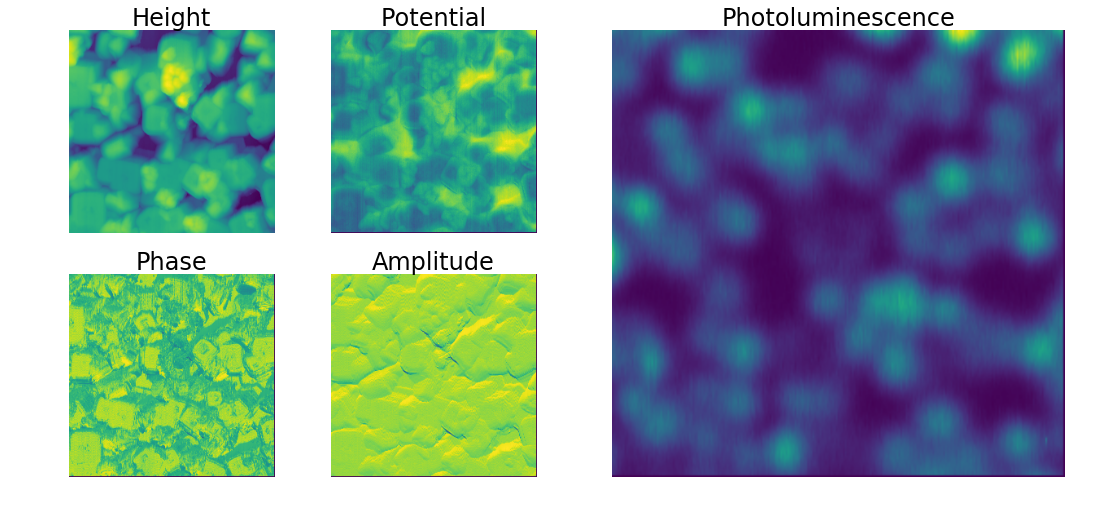

In [2]:
Ht2 = np.loadtxt('MABr.1.Ht.txt',skiprows=0, dtype=np.float64)
Po2 = np.loadtxt('MABr.1.Po.txt',skiprows=0, dtype=np.float64)
Ph2 = np.loadtxt('MABr.1.Ph.txt',skiprows=0, dtype=np.float64)
Am2 = np.loadtxt('MABr.1.Am.txt',skiprows=0, dtype=np.float64)
Pl2 = np.loadtxt('MABr.1.Pl.txt',skiprows=0, dtype=np.float64)

fig = plt.figure(figsize=(18,8))
ht_ax = fig.add_subplot(241)
po_ax = fig.add_subplot(242)
ph_ax = fig.add_subplot(245)
am_ax = fig.add_subplot(246)
pl_ax = fig.add_subplot(122)

ht_ax.imshow(Ht2, cmap='viridis')#cmap='afmhot'
ht_ax.set_title('Height')
ht_ax.axis('off')

po_ax.imshow(Po2, cmap='viridis')#, cmap='cubehelix'
po_ax.set_title('Potential')
po_ax.axis('off')

ph_ax.imshow(Ph2, cmap='viridis')
ph_ax.set_title('Phase')
ph_ax.axis('off')

am_ax.imshow(Am2, cmap='viridis')
am_ax.set_title('Amplitude')
am_ax.axis('off')

pl_ax.imshow(Pl2, cmap='viridis')
pl_ax.set_title('Photoluminescence')
pl_ax.axis('off')

# flatten the images
Ht2_flat = Ht2.flatten()
Po2_flat = Po2.flatten()
Ph2_flat = Ph2.flatten()
Am2_flat = Am2.flatten()
Pl2_flat = Pl2.flatten()

plt.show()

## Regression Using Random Forests
We'll use a decision tree estimator in scikit-learn: ``sklearn.ensemble.RandomForestRegressor``

I'll start with the simple case of giving each pixel one feature from each image:

In [3]:
X = [Ht2_flat, Po2_flat, Ph2_flat, Am2_flat]
X = np.array(X).T
Y = np.array(Pl2_flat).T
print(X.shape)
print(Y.shape)

(63250, 4)
(63250,)


In [4]:
clf = DecisionTreeRegressor()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, random_state=0)
clf = DecisionTreeRegressor(max_depth=11)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

In [5]:
metrics.mean_squared_error(ytest, ypred)

0.14072054644413426

<a id='single'></a>

### Let's do this again without train_test_split so we can recreate the images

[back to top](#top)

0.127809932007


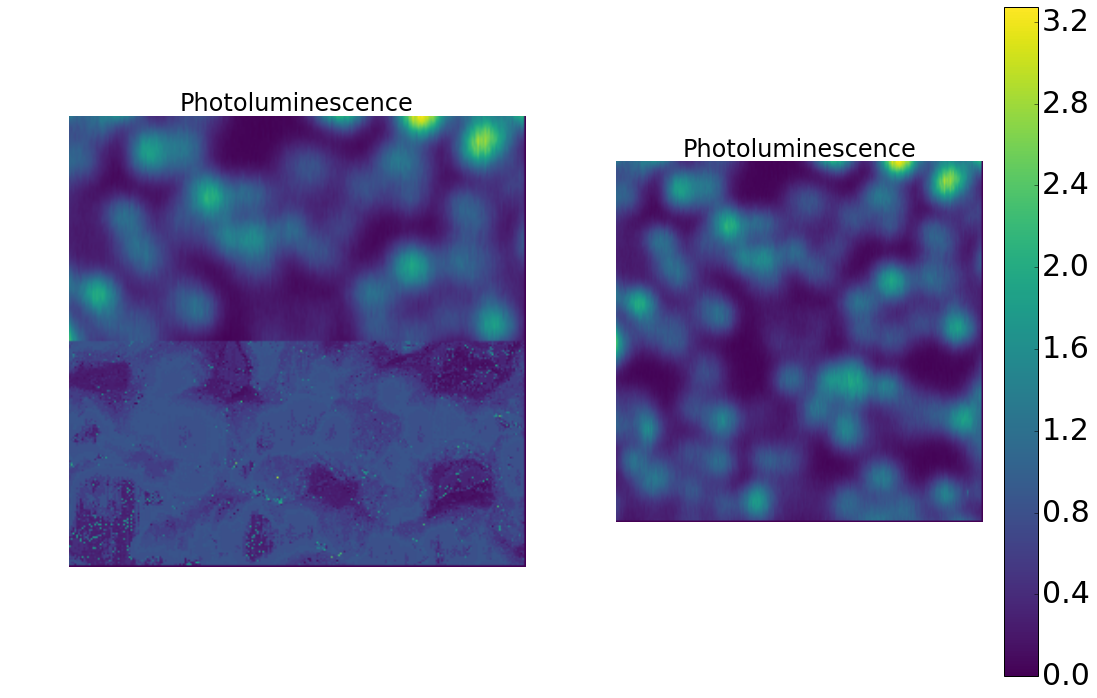

In [7]:
Xtrain = np.array([Ht2_flat[0:31625], Po2_flat[0:31625], Ph2_flat[0:31625], Am2_flat[0:31625]]).T
Xtest = np.array([Ht2_flat[31625:], Po2_flat[31625:], Ph2_flat[31625:], Am2_flat[31625:]]).T
Ytrain = np.array(Pl2_flat[0:31625])
Ytest = np.array(Pl2_flat[31625:])
clf = DecisionTreeRegressor(max_depth=11)
clf.fit(Xtrain, Ytrain)
Ypred = clf.predict(Xtest)
print(metrics.mean_squared_error(Ytest, Ypred))

x = Ht2.shape[0]
y = Ht2.shape[1]
k=0
merge = np.concatenate((Ytrain,Ypred))
Pl_predict = np.zeros((x,y))
for i in range(x):
    for j in range (y):
        Pl_predict[i,j] = merge[k]
        k = k + 1
        
fig = plt.figure(figsize=(18,12))
pl_ax = fig.add_subplot(121)
pl_ax.imshow(Pl_predict, cmap='viridis')
pl_ax.set_title('Photoluminescence')
pl_ax.axis('off')
pl_ax = fig.add_subplot(122)
cax = pl_ax.imshow(Pl2, cmap='viridis')
pl_ax.set_title('Photoluminescence')
pl_ax.axis('off')

fig.colorbar(cax)


## 15x15 array with MSE's (stored array)

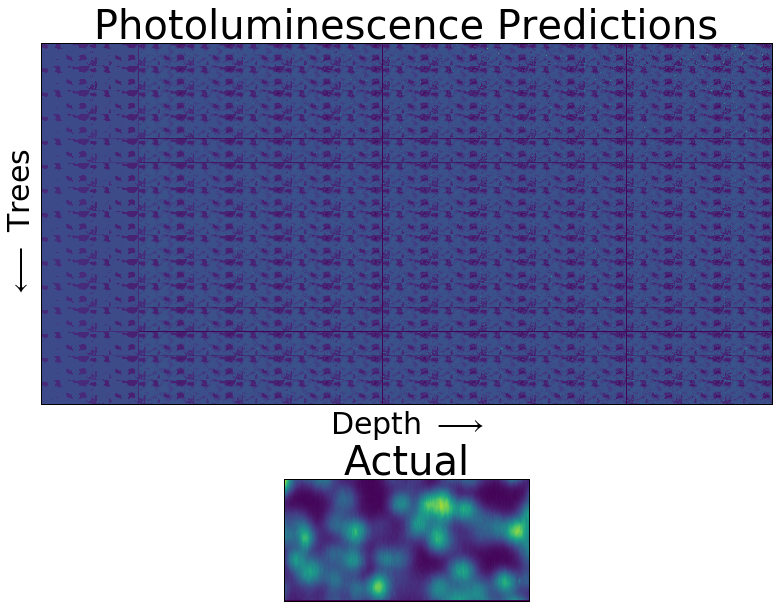

In [11]:
Xtrain = np.array([Ht2_flat[0:31625], Po2_flat[0:31625], Ph2_flat[0:31625], Am2_flat[0:31625]]).T
Xtest = np.array([Ht2_flat[31625:], Po2_flat[31625:], Ph2_flat[31625:], Am2_flat[31625:]]).T
Ytrain = np.array(Pl2_flat[0:31625])
Ytest = np.array(Pl2_flat[31625:])

depths = 15
trees = 15
x = Ht2.shape[0]/2*trees
y = Ht2.shape[1]
k=0
prediction = []
scores = []

for q in range(1,depths+1):
    for r in range(1,trees+1):
        clf = RandomForestRegressor(max_depth=q, n_estimators=r, bootstrap=True)
        clf.fit(Xtrain, Ytrain)
        hold = clf.predict(Xtest)
        scores.append(metrics.mean_squared_error(Ytest, hold))
        prediction.append(hold)
        k = k + 1
    

k=0
merge = (np.array(prediction).flatten())
Pl_predict = np.zeros((x,y*depths))
for l in range(depths):
    for i in range(x):
        for j in range (y):
            Pl_predict[i,j+(l*y)] = merge[k]
            k = k + 1

fig = plt.figure(figsize=(20,10))
pl_ax = fig.add_subplot(3,1,(1,2))
pl_ax.imshow(Pl_predict, cmap='viridis')#seismic
pl_ax.set_title('Photoluminescence Predictions', size=40)
pl_ax.set_ylabel('$\longleftarrow$ Trees', size=30)
pl_ax.set_xlabel('Depth $\longrightarrow$', size=30)
pl_ax.axes.get_xaxis().set_ticks([])
pl_ax.axes.get_yaxis().set_ticks([])

pl_ax2 = fig.add_subplot(4,1,4)
pl_ax2.set_title('Actual', size=40)
pl_ax2.imshow(Pl2[Pl2.shape[0]/2:,:], cmap='viridis')
pl_ax2.axes.get_xaxis().set_ticks([])
pl_ax2.axes.get_yaxis().set_ticks([])

fig.savefig(filename='afm_depth', bbox_inches='tight', dpi=900)

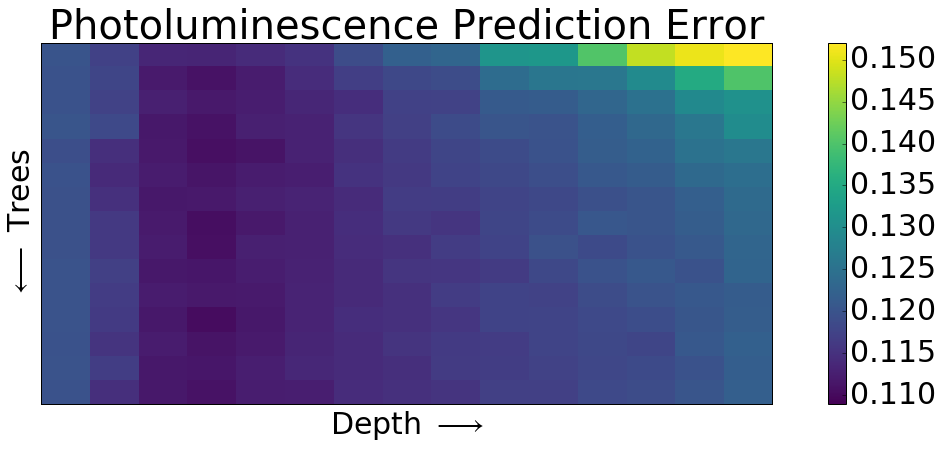

In [12]:
k=0
merge = (np.array(prediction).flatten())
Pl_predict = np.zeros((x,y*depths))
for l in range(depths):
    for i in range(trees):
        for a in range(125):
            for j in range (y):
                Pl_predict[a+(125*i),j+(l*y)] = scores[k]
        k = k + 1

fig = plt.figure(figsize=(20,10))
fig.clf()
pl_ax = fig.add_subplot(3,1,(1,2))
cax = pl_ax.imshow(Pl_predict, interpolation='nearest', cmap='viridis', vmin=0.109, vmax=0.152)#seismic
fig.colorbar(cax)


pl_ax.set_title('Photoluminescence Prediction Error', size=40)
pl_ax.set_ylabel('$\longleftarrow$ Trees', size=30)
pl_ax.set_xlabel('Depth $\longrightarrow$', size=30)
pl_ax.axes.get_xaxis().set_ticks([])
pl_ax.axes.get_yaxis().set_ticks([])



fig.savefig(filename='afm_depth_score', bbox_inches='tight')

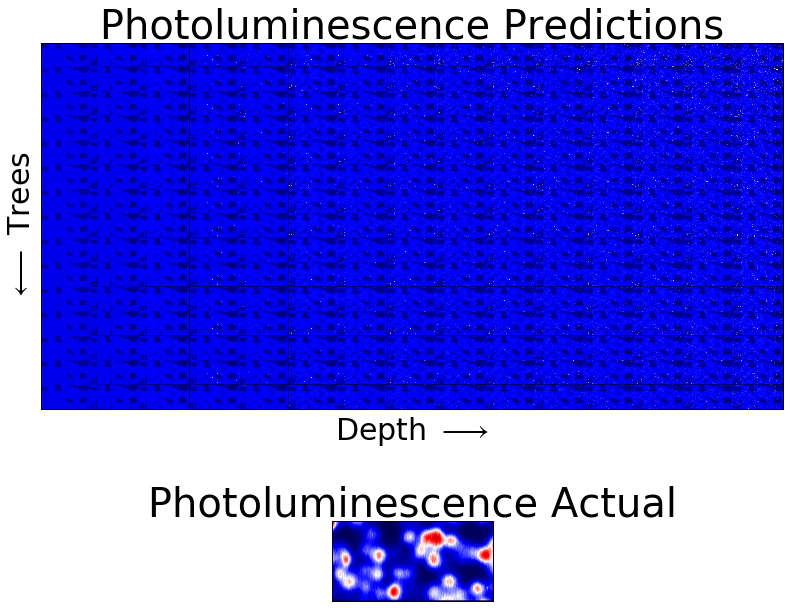

In [12]:
x = Ht2.shape[0]/2*trees
y = Ht2.shape[1]
k=0
merge = (np.array(prediction).flatten())
Pl_predict = np.zeros((x,y*depths))
for l in range(depths):
    for i in range(x):
        for j in range (y):
            Pl_predict[i,j+(l*y)] = merge[k]
            k = k + 1

fig = plt.figure(figsize=(30,10))
pl_ax = fig.add_subplot(6,4,(1,16))
pl_ax.imshow(Pl_predict, cmap='seismic')
pl_ax.set_title('Photoluminescence Predictions', size=40)
pl_ax.set_ylabel('$\longleftarrow$ Trees', size=30)
pl_ax.set_xlabel('Depth $\longrightarrow$', size=30)
pl_ax.axes.get_xaxis().set_ticks([])
pl_ax.axes.get_yaxis().set_ticks([])
pl_ax2 = fig.add_subplot(6,4,(21,24))
pl_ax2.set_title('Photoluminescence Actual', size=40)
pl_ax2.imshow(Pl2[Pl2.shape[0]/2:,:], cmap='seismic')
pl_ax2.axes.get_xaxis().set_ticks([])
pl_ax2.axes.get_yaxis().set_ticks([])
fig.savefig(filename='afm_depth', bbox_inches='tight', dpi=300)

# Direct small multiple load

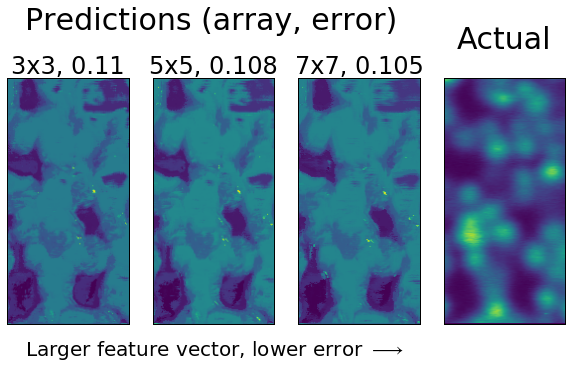

In [8]:
###User specified parameters
inputs = [Ht2, Po2, Ph2, Am2]
x7x7 = [-3, -2, -1, 0, 1, 2, 3]
x5x5 = [-2, -1, 0, 1, 2]
x3x3 = [-1, 0, 1]
scores = [0.11, 0.108, 0.105]

stuff = [x3x3, x5x5, x7x7]
morestuff = ['3x3', '5x5', '7x7']
depths = 1
trees = 1

###Create training and testing arrays
x = Po2.shape[0]/2
x2 = Po2.shape[0]
y = Po2.shape[1]

fig = plt.figure(figsize=(10,10))

for wes in range(3):
    pixelContext = stuff[wes]

    Pl_predict = np.load('%s.npy' %(morestuff[wes]))
    
    if wes == 2:
        pl_ax.text(-130,-50,'Predictions (array, error)', size=30)#.set_position([.5, 1.2])
        pl_ax.text(-130,280, 'Larger feature vector, lower error $\longrightarrow$')
    pl_ax = fig.add_subplot(1,4,(wes+1))

    pl_ax.imshow(Pl_predict.T, cmap='viridis')
    #pl_ax.set_title('%s Feature Vector, score: %s' %(morestuff[wes],scores[wes]), size=24)
    #pl_ax.set_ylabel('$\longleftarrow$ Trees', size=30)
    #pl_ax.set_xlabel('Depth $\longrightarrow$', size=30)
    pl_ax.axes.get_xaxis().set_ticks([])
    pl_ax.axes.get_yaxis().set_ticks([])
    pl_ax.set_title('%s, %s' %(morestuff[wes],scores[wes]), size=24)
pl_ax2 = fig.add_subplot(1,4,4)

pl_ax2.set_title('Actual', size=30).set_position([.5, 1.1])
pl_ax2.imshow(Pl2[Pl2.shape[0]/2:,:].T, cmap='viridis')
pl_ax2.axes.get_xaxis().set_ticks([])
pl_ax2.axes.get_yaxis().set_ticks([])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,\
                    wspace=None, hspace=None)
fig.savefig(filename='vector_variation_small_multiple', bbox_inches='tight')

0.11
0.108
0.106


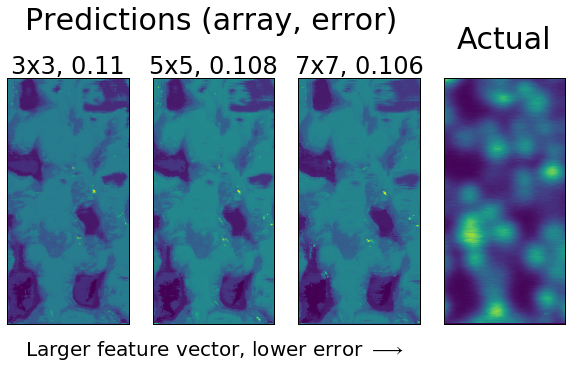

In [9]:
###User specified parameters
inputs = [Ht2, Po2, Ph2, Am2]
x7x7 = [-3, -2, -1, 0, 1, 2, 3]
x5x5 = [-2, -1, 0, 1, 2]
x3x3 = [-1, 0, 1]

stuff = [x3x3, x5x5, x7x7]
morestuff = ['3x3', '5x5', '7x7']
depths = 1
trees = 1

###Create training and testing arrays
x = Po2.shape[0]/2
x2 = Po2.shape[0]
y = Po2.shape[1]

fig = plt.figure(figsize=(10,10))

for wes in range(3):
    pixelContext = stuff[wes]
    Xtrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0

    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtrain[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Xtest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtest[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Ytrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0 
    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytrain[k]=Pl2[p,q]
            k = k + 1

    Ytest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytest[k]=Pl2[p,q]
            k = k + 1

###Run Algorithm
    k=0
    prediction = []
    q=5
    n=50

    clf = RandomForestRegressor(max_depth=q, n_estimators=n, bootstrap=True)
    clf.fit(Xtrain, Ytrain)
    hold = clf.predict(Xtest)
    score = metrics.mean_squared_error(Ytest, hold)
    roundscore = myround(score, 0.001)
    print(roundscore)
    prediction.append(hold)
    k = k + 1

    k=0
    merge = (np.array(prediction).flatten())
    Pl_predict = np.zeros(((x-max(pixelContext))*trees,(y-(max(pixelContext)*2))*depths))
    for l in range(depths):
        for i in range((x-max(pixelContext))*trees):
            for j in range (y-(max(pixelContext)*2)):
                Pl_predict[i,j+(l*(y-(max(pixelContext)*2)))] = merge[k]
                k = k + 1
    np.save('%s' %(morestuff[wes]),Pl_predict)
    
    if wes == 2:
        pl_ax.text(-130,-50,'Predictions (array, error)', size=30)#.set_position([.5, 1.2])
        pl_ax.text(-130,280, 'Larger feature vector, lower error $\longrightarrow$')
    pl_ax = fig.add_subplot(1,4,(wes+1))

    pl_ax.imshow(Pl_predict.T, cmap='viridis')
    #pl_ax.set_title('%s Feature Vector, score: %s' %(morestuff[wes],scores[wes]), size=24)
    #pl_ax.set_ylabel('$\longleftarrow$ Trees', size=30)
    #pl_ax.set_xlabel('Depth $\longrightarrow$', size=30)
    pl_ax.axes.get_xaxis().set_ticks([])
    pl_ax.axes.get_yaxis().set_ticks([])
    pl_ax.set_title('%s, %s' %(morestuff[wes],roundscore), size=24)
pl_ax2 = fig.add_subplot(1,4,4)

pl_ax2.set_title('Actual', size=30).set_position([.5, 1.1])
pl_ax2.imshow(Pl2[Pl2.shape[0]/2:,:].T, cmap='viridis')
pl_ax2.axes.get_xaxis().set_ticks([])
pl_ax2.axes.get_yaxis().set_ticks([])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,\
                    wspace=None, hspace=None)
fig.savefig(filename='vector_variation_MABr', bbox_inches='tight')

<a id='double'></a>
# Double Scan Approach

[back to top](#top)

0.11
0.108
0.106


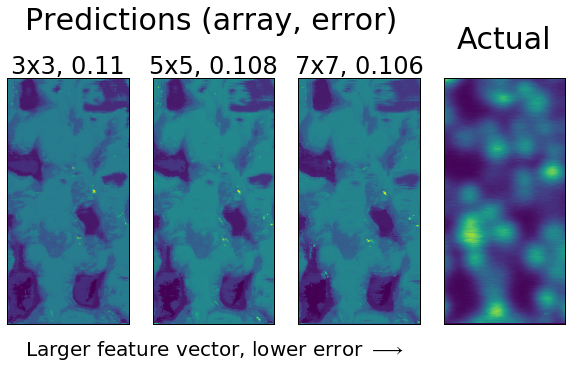

In [9]:
###User specified parameters
inputs = [Ht2, Po2, Ph2, Am2]
x7x7 = [-3, -2, -1, 0, 1, 2, 3]
x5x5 = [-2, -1, 0, 1, 2]
x3x3 = [-1, 0, 1]

stuff = [x3x3, x5x5, x7x7]
morestuff = ['3x3', '5x5', '7x7']
depths = 1
trees = 1

###Create training and testing arrays
x = Po2.shape[0]/2
x2 = Po2.shape[0]
y = Po2.shape[1]

fig = plt.figure(figsize=(10,10))

for wes in range(3):
    pixelContext = stuff[wes]
###FOR FIRST ALGORITHM
    Xtrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0
    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtrain[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Xtest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtest[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Ytrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0 
    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytrain[k]=Pl2[p,q]
            k = k + 1

    Ytest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytest[k]=Pl2[p,q]
            k = k + 1
###FOR SECOND ALGORITHM
    Xtrain2 = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0
    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtrain2[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Xtest2 = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtest2[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Ytrain2 = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0 
    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytrain2[k]=Pl2[p,q]
            k = k + 1

    Ytest2 = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytest2[k]=Pl2[p,q]
            k = k + 1
    ###Run Algorithm
    k=0
    prediction = []
    q=5
    n=50

    clf = RandomForestRegressor(max_depth=q, n_estimators=n, bootstrap=True)
    clf.fit(Xtrain, Ytrain)
    hold = clf.predict(Xtest)
    score = metrics.mean_squared_error(Ytest, hold)
    roundscore = myround(score, 0.001)
    print(roundscore)
    prediction.append(hold)
    k = k + 1

    k=0
    merge = (np.array(prediction).flatten())
    Pl_predict = np.zeros(((x-max(pixelContext))*trees,(y-(max(pixelContext)*2))*depths))
    for l in range(depths):
        for i in range((x-max(pixelContext))*trees):
            for j in range (y-(max(pixelContext)*2)):
                Pl_predict[i,j+(l*(y-(max(pixelContext)*2)))] = merge[k]
                k = k + 1
    np.save('%s' %(morestuff[wes]),Pl_predict)
    
    if wes == 2:
        pl_ax.text(-130,-50,'Predictions (array, error)', size=30)#.set_position([.5, 1.2])
        pl_ax.text(-130,280, 'Larger feature vector, lower error $\longrightarrow$')
    pl_ax = fig.add_subplot(1,4,(wes+1))

    pl_ax.imshow(Pl_predict.T, cmap='viridis')
    #pl_ax.set_title('%s Feature Vector, score: %s' %(morestuff[wes],scores[wes]), size=24)
    #pl_ax.set_ylabel('$\longleftarrow$ Trees', size=30)
    #pl_ax.set_xlabel('Depth $\longrightarrow$', size=30)
    pl_ax.axes.get_xaxis().set_ticks([])
    pl_ax.axes.get_yaxis().set_ticks([])
    pl_ax.set_title('%s, %s' %(morestuff[wes],roundscore), size=24)
pl_ax2 = fig.add_subplot(1,4,4)

pl_ax2.set_title('Actual', size=30).set_position([.5, 1.1])
pl_ax2.imshow(Pl2[Pl2.shape[0]/2:,:].T, cmap='viridis')
pl_ax2.axes.get_xaxis().set_ticks([])
pl_ax2.axes.get_yaxis().set_ticks([])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,\
                    wspace=None, hspace=None)
fig.savefig(filename='vector_variation_MABr', bbox_inches='tight')

0.121401065527


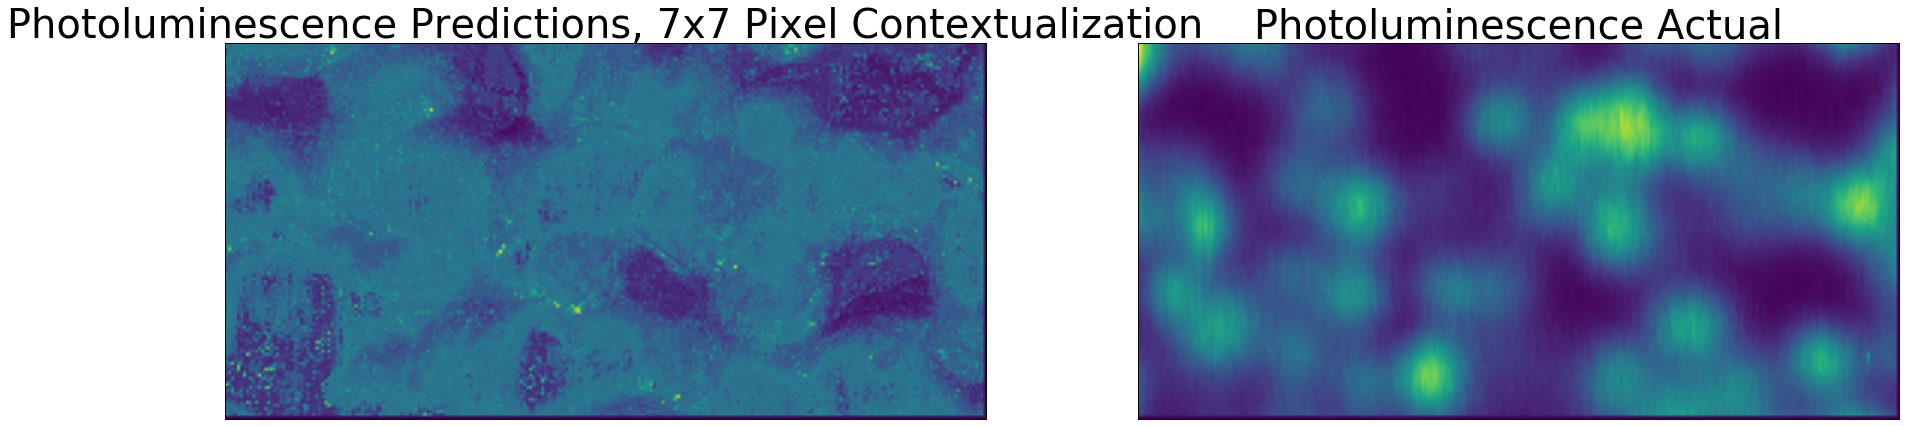

In [14]:
###User specified parameters
inputs = [Ht2, Po2, Ph2, Am2]
x7x7 = [-3, -2, -1, 0, 1, 2, 3]
x5x5 = [-2, -1, 0, 1, 2]
x3x3 = [-1, 0, 1]
x1x1 = [0]
pixelContext = x1x1
depths = 1
trees = 1

###Create training and testing arrays
x = Po2.shape[0]/2
x2 = Po2.shape[0]
y = Po2.shape[1]

Xtrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                *len(inputs))))
k=0

for p in range(max(pixelContext),x):
    for q in range(max(pixelContext),y-max(pixelContext)):
        j=0
        for h, i in enumerate(inputs):
            for l in pixelContext:
                for m in pixelContext:
                    Xtrain[k,j]=i[(p+l),(q+m)]
                    j=j+1
        k = k + 1

Xtest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                *len(inputs))))
k=0
for p in range(x,x2-max(pixelContext)):
    for q in range(max(pixelContext),y-max(pixelContext)):
        j=0
        for h, i in enumerate(inputs):
            for l in pixelContext:
                for m in pixelContext:
                    Xtest[k,j]=i[(p+l),(q+m)]
                    j=j+1
        k = k + 1

Ytrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
k=0 
for p in range(max(pixelContext),x):
    for q in range(max(pixelContext),y-max(pixelContext)):
        Ytrain[k]=Pl2[p,q]
        k = k + 1
              
Ytest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
k=0
for p in range(x,x2-max(pixelContext)):
    for q in range(max(pixelContext),y-max(pixelContext)):
        Ytest[k]=Pl2[p,q]
        k = k + 1

###Run Algorithm
k=0
prediction = []
q=15
n=15

clf = RandomForestRegressor(max_depth=q, n_estimators=n, bootstrap=True)
clf.fit(Xtrain, Ytrain)
hold = clf.predict(Xtest)
print(metrics.mean_squared_error(Ytest, hold))
prediction.append(hold)
k = k + 1
    
k=0
merge = (np.array(prediction).flatten())
Pl_predict = np.zeros(((x-max(pixelContext))*trees,(y-(max(pixelContext)*2))*depths))
for l in range(depths):
    for i in range((x-max(pixelContext))*trees):
        for j in range (y-(max(pixelContext)*2)):
            Pl_predict[i,j+(l*(y-(max(pixelContext)*2)))] = merge[k]
            k = k + 1

fig = plt.figure(figsize=(30,10))
pl_ax = fig.add_subplot(1,2,1)

pl_ax.imshow(Pl_predict, cmap='viridis')
pl_ax.set_title('Photoluminescence Predictions, 7x7 Pixel Contextualization', size=40)
#pl_ax.set_ylabel('$\longleftarrow$ Trees', size=30)
#pl_ax.set_xlabel('Depth $\longrightarrow$', size=30)
pl_ax.axes.get_xaxis().set_ticks([])
pl_ax.axes.get_yaxis().set_ticks([])
pl_ax2 = fig.add_subplot(1,2,2)
pl_ax2.set_title('Photoluminescence Actual', size=40)
pl_ax2.imshow(Pl2[Pl2.shape[0]/2:,:], cmap='viridis')
pl_ax2.axes.get_xaxis().set_ticks([])
pl_ax2.axes.get_yaxis().set_ticks([])
fig.savefig(filename='1x1', bbox_inches='tight', dpi=300)

# Code Graveyard

In [65]:
pixelContext = [-2, -1, 0, 1, 2]
range(pixelContext)

TypeError: range() integer end argument expected, got list.

In [179]:
x = Po2.shape[0]/2
x2 = Po2.shape[0]
y = Po2.shape[1]
Xtest = np.zeros(((y-2)*(x-1),9))
k=0
for p in range(x,x2-1):
    for q in range(1,y-1):
        Xtest[k,0]=Po2[p-1,q-1]
        Xtest[k,1]=Po2[p-1,q]
        Xtest[k,2]=Po2[p-1,q+1]
        Xtest[k,3]=Po2[p,q-1]
        Xtest[k,4]=Po2[p,q]
        Xtest[k,5]=Po2[p,q+1]
        Xtest[k,6]=Po2[p+1,q-1]
        Xtest[k,7]=Po2[p+1,q]
        Xtest[k,8]=Po2[p+1,q+1]
        k = k + 1

In [155]:
x = Po2.shape[0]/2
x2 = Po2.shape[0]
y = Po2.shape[1]
Xtrain = np.zeros(((y-2)*(x-1),9))
k=0
for p in range(1,x):
    for q in range(1,y-1):
        Xtrain[k,0]=Po2[p-1,q-1]
        Xtrain[k,1]=Po2[p-1,q]
        Xtrain[k,2]=Po2[p-1,q+1]
        Xtrain[k,3]=Po2[p,q-1]
        Xtrain[k,4]=Po2[p,q]
        Xtrain[k,5]=Po2[p,q+1]
        Xtrain[k,6]=Po2[p+1,q-1]
        Xtrain[k,7]=Po2[p+1,q]
        Xtrain[k,8]=Po2[p+1,q+1]
        k = k + 1

In [189]:
1255/5

251

In [40]:
splitx = len(Ht2[:,0])/2
splity = len(Ht2[0,:])/2

###set X train/test data
sets = [Ht2, Po2, Ph2, Am2]
for p, q in enumerate(sets): #select top left quadrant for testing
    iarray = q 
    x = iarray.shape[0]/2
    y = iarray.shape[1]/2
    k=0
    test = np.zeros((x*y))
    for i in range(0,x):
        for j in range (0,y):
            test[k] = iarray[i,j]
            k = k + 1
            sets[p] = test
Xtest = np.array(sets).T

sets = [Ht2, Po2, Ph2, Am2]
for p, q in enumerate(sets): #select top right and bottom half quadrants for training
    iarray = q 
    xstart = iarray.shape[0]/2+1 #don't overlap with test set
    xend = iarray.shape[0]
    y = iarray.shape[1]/2
    k=0
    test = np.zeros((x*y*3))
    for i in range(xstart,xend):
        for j in range (0,y):
            test[k] = iarray[i,j]
            k = k + 1
    x = iarray.shape[0]    
    ystart = iarray.shape[1]/2+1 #don't overlap with test set
    yend = iarray.shape[1]
    for i in range(x):
        for j in range(ystart,yend):
            test[k] = iarray[i,j]
            k = k + 1
            sets[p] = test
Xtrain = np.array(sets).T

###Set Y train/test data
sets = [Pl2]
for p, q in enumerate(sets): #select top left quadrant for testing
    iarray = q 
    x = iarray.shape[0]/2
    y = iarray.shape[1]/2
    k=0
    test = np.zeros((x*y))
    for i in range(0,x):
        for j in range (0,y):
            test[k] = iarray[i,j]
            k = k + 1
            sets[p] = test
Ytest = np.array(sets)

sets = [Pl2]
for p, q in enumerate(sets): #select top right and bottom half quadrants for training
    iarray = q 
    xstart = iarray.shape[0]/2+1 #don't overlap with test set
    xend = iarray.shape[0]
    y = iarray.shape[1]/2
    k=0
    test = np.zeros((x*y*3))
    for i in range(xstart,xend):
        for j in range (0,y):
            test[k] = iarray[i,j]
            k = k + 1
    x = iarray.shape[0]    
    ystart = iarray.shape[1]/2+1 #don't overlap with test set
    yend = iarray.shape[1]
    for i in range(x):
        for j in range(ystart,yend):
            test[k] = iarray[i,j]
            k = k + 1
            sets[p] = test
Ytrain = np.array(sets)

clf = DecisionTreeRegressor(max_depth=11)
clf.fit(Xtrain, Ytrain)
Ypred = clf.predict(Xtest)
print(metrics.mean_squared_error(Ytest, Ypred))

ValueError: setting an array element with a sequence.

In [42]:
sets = [Ht2, Po2, Ph2, Am2]
for p, q in enumerate(sets): #select top right and bottom half quadrants for training
    iarray = q 
    xstart = iarray.shape[0]/2+1 #don't overlap with test set
    xend = iarray.shape[0]
    y = iarray.shape[1]/2
    k=0
    test = np.zeros((x*y*3))
    for i in range(xstart,xend):
        for j in range (0,y):
            test[k] = iarray[i,j]
            k = k + 1
    x = iarray.shape[0]    
    ystart = iarray.shape[1]/2+1 #don't overlap with test set
    yend = iarray.shape[1]
    for i in range(x):
        for j in range(ystart,yend):
            test[k] = iarray[i,j]
            k = k + 1
            sets[p] = test
Xtrain = np.array(sets).T
Xtrain

array([[  6.18112720e-07,   1.33575200e-01,   1.15485640e+02,
          7.22029800e-08],
       [  5.99718760e-07,   1.32123230e-01,   1.06134050e+02,
          7.17905520e-08],
       [  5.79463630e-07,   1.44206290e-01,   8.59347990e+01,
          7.41465910e-08],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00]])

0.127730308894


(-0.5, 252.5, 249.5, -0.5)

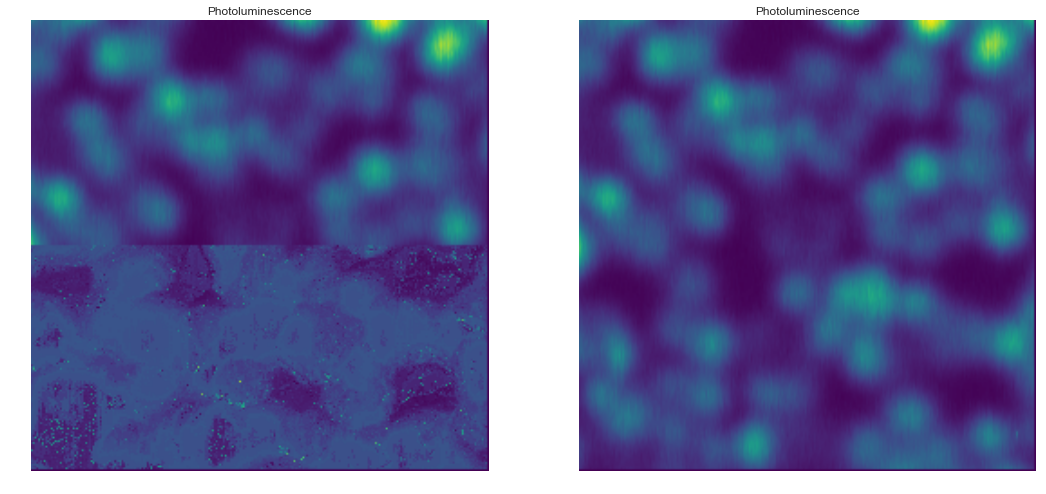

In [37]:
Xtrain = np.array([Ht2_flat[0:31625], Po2_flat[0:31625], Ph2_flat[0:31625], Am2_flat[0:31625]]).T
Xtest = np.array([Ht2_flat[31625:], Po2_flat[31625:], Ph2_flat[31625:], Am2_flat[31625:]]).T
Ytrain = np.array(Pl2_flat[0:31625])
Ytest = np.array(Pl2_flat[31625:])
clf = DecisionTreeRegressor(max_depth=11)
clf.fit(Xtrain, Ytrain)
Ypred = clf.predict(Xtest)
print(metrics.mean_squared_error(Ytest, Ypred))

x = Ht2.shape[0]
y = Ht2.shape[1]
k=0
merge = np.concatenate((Ytrain,Ypred))
Pl_predict = np.zeros((x,y))
for i in range(x):
    for j in range (y):
        Pl_predict[i,j] = merge[k]
        k = k + 1
        
fig = plt.figure(figsize=(18,12))
pl_ax = fig.add_subplot(121)
pl_ax.imshow(Pl_predict, cmap='viridis')
pl_ax.set_title('Photoluminescence')
pl_ax.axis('off')
pl_ax = fig.add_subplot(122)
pl_ax.imshow(Pl2, cmap='viridis')
pl_ax.set_title('Photoluminescence')
pl_ax.axis('off')

0.112600240336
0.111817687556
0.111046763305
0.111108663076
0.111146193959
0.111226166507
0.111509458383
0.111122823988
0.111201128727
0.111446151054
0.10646846039
0.106439146098
0.106560490835
0.10628316616
0.106400452078
0.106329613758
0.107024577601
0.106728723184
0.106879322853
0.106357330324
0.109930474904
0.108490875748
0.107047820858
0.105777970843
0.106169330445
0.106517573579
0.106845567727
0.107805113722
0.106806227025
0.107987135248
0.112457512965
0.11225698966
0.110962324141
0.109251791631
0.109129432523
0.109242808627
0.110465886949
0.111861198759
0.111648741767
0.109123646439
0.120276177198
0.112754432749
0.110536752939
0.111825887441
0.111256792077
0.110975610777
0.111950608967
0.111379011758
0.111865100722
0.110757453111
0.119917350814
0.115473293175
0.114969161175
0.114233691386
0.112348344292
0.112722631964
0.113015767626
0.112348637128
0.112333031564
0.112699959302
0.125153640973
0.117822184818
0.115579295678
0.114566175323
0.117100822241
0.11617599285
0.114041587371

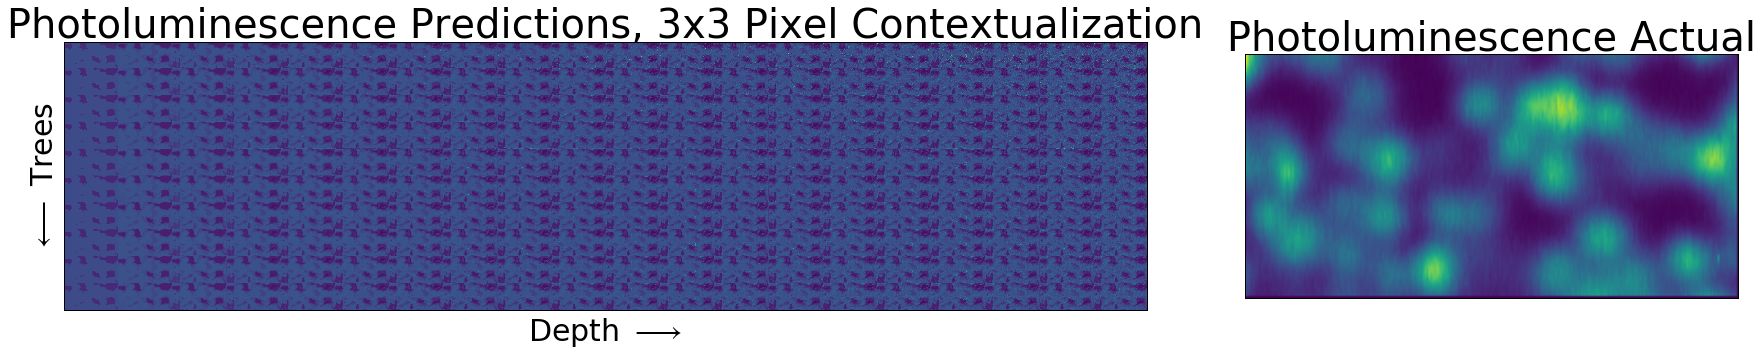

In [13]:
x = Po2.shape[0]/2
x2 = Po2.shape[0]
y = Po2.shape[1]

Xtrain = np.zeros(((y-2)*(x-1),36))
k=0
for p in range(1,x):
    for q in range(1,y-1):
        Xtrain[k,0]=Ht2[p-1,q-1]
        Xtrain[k,1]=Ht2[p-1,q]
        Xtrain[k,2]=Ht2[p-1,q+1]
        Xtrain[k,3]=Ht2[p,q-1]
        Xtrain[k,4]=Ht2[p,q]
        Xtrain[k,5]=Ht2[p,q+1]
        Xtrain[k,6]=Ht2[p+1,q-1]
        Xtrain[k,7]=Ht2[p+1,q]
        Xtrain[k,8]=Ht2[p+1,q+1]
        Xtrain[k,9]=Po2[p-1,q-1]
        Xtrain[k,10]=Po2[p-1,q]
        Xtrain[k,11]=Po2[p-1,q+1]
        Xtrain[k,12]=Po2[p,q-1]
        Xtrain[k,13]=Po2[p,q]
        Xtrain[k,14]=Po2[p,q+1]
        Xtrain[k,15]=Po2[p+1,q-1]
        Xtrain[k,16]=Po2[p+1,q]
        Xtrain[k,17]=Po2[p+1,q+1]
        Xtrain[k,18]=Ph2[p-1,q-1]
        Xtrain[k,19]=Ph2[p-1,q]
        Xtrain[k,20]=Ph2[p-1,q+1]
        Xtrain[k,21]=Ph2[p,q-1]
        Xtrain[k,22]=Ph2[p,q]
        Xtrain[k,23]=Ph2[p,q+1]
        Xtrain[k,24]=Ph2[p+1,q-1]
        Xtrain[k,25]=Ph2[p+1,q]
        Xtrain[k,26]=Ph2[p+1,q+1]
        Xtrain[k,27]=Am2[p-1,q-1]
        Xtrain[k,28]=Am2[p-1,q]
        Xtrain[k,29]=Am2[p-1,q+1]
        Xtrain[k,30]=Am2[p,q-1]
        Xtrain[k,31]=Am2[p,q]
        Xtrain[k,32]=Am2[p,q+1]
        Xtrain[k,33]=Am2[p+1,q-1]
        Xtrain[k,34]=Am2[p+1,q]
        Xtrain[k,35]=Am2[p+1,q+1]
        k = k + 1

Xtest = np.zeros(((y-2)*(x-1),36))
k=0
for p in range(x,x2-1):
    for q in range(1,y-1):
        Xtest[k,0]=Ht2[p-1,q-1]
        Xtest[k,1]=Ht2[p-1,q]
        Xtest[k,2]=Ht2[p-1,q+1]
        Xtest[k,3]=Ht2[p,q-1]
        Xtest[k,4]=Ht2[p,q]
        Xtest[k,5]=Ht2[p,q+1]
        Xtest[k,6]=Ht2[p+1,q-1]
        Xtest[k,7]=Ht2[p+1,q]
        Xtest[k,8]=Ht2[p+1,q+1]
        Xtest[k,9]=Po2[p-1,q-1]
        Xtest[k,10]=Po2[p-1,q]
        Xtest[k,11]=Po2[p-1,q+1]
        Xtest[k,12]=Po2[p,q-1]
        Xtest[k,13]=Po2[p,q]
        Xtest[k,14]=Po2[p,q+1]
        Xtest[k,15]=Po2[p+1,q-1]
        Xtest[k,16]=Po2[p+1,q]
        Xtest[k,17]=Po2[p+1,q+1]
        Xtest[k,18]=Ph2[p-1,q-1]
        Xtest[k,19]=Ph2[p-1,q]
        Xtest[k,20]=Ph2[p-1,q+1]
        Xtest[k,21]=Ph2[p,q-1]
        Xtest[k,22]=Ph2[p,q]
        Xtest[k,23]=Ph2[p,q+1]
        Xtest[k,24]=Ph2[p+1,q-1]
        Xtest[k,25]=Ph2[p+1,q]
        Xtest[k,26]=Ph2[p+1,q+1]
        Xtest[k,27]=Am2[p-1,q-1]
        Xtest[k,28]=Am2[p-1,q]
        Xtest[k,29]=Am2[p-1,q+1]
        Xtest[k,30]=Am2[p,q-1]
        Xtest[k,31]=Am2[p,q]
        Xtest[k,32]=Am2[p,q+1]
        Xtest[k,33]=Am2[p+1,q-1]
        Xtest[k,34]=Am2[p+1,q]
        Xtest[k,35]=Am2[p+1,q+1]
        k = k + 1


Ytrain = np.zeros(((y-2)*(x-1)))
k=0 
for p in range(1,x):
    for q in range(1,y-1):
        Ytrain[k]=Pl2[p,q]
        k = k + 1
              
Ytest = np.zeros(((y-2)*(x-1)))
k=0
for p in range(x,x2-1):
    for q in range(1,y-1):
        Ytest[k]=Pl2[p,q]
        k = k + 1

depths = 20
trees = 10
k=0
prediction = []

for q in range(1,depths+1):
    for r in range(1,trees+1):
        clf = RandomForestRegressor(max_depth=q, n_estimators=r, bootstrap=True)
        clf.fit(Xtrain, Ytrain)
        hold = clf.predict(Xtest)
        print(metrics.mean_squared_error(Ytest, hold))
        prediction.append(hold)
        k = k + 1
    

k=0
merge = (np.array(prediction).flatten())
Pl_predict = np.zeros(((x-1)*trees,(y-2)*depths))
for l in range(depths):
    for i in range((x-1)*trees):
        for j in range (y-2):
            Pl_predict[i,j+(l*(y-2))] = merge[k]
            k = k + 1

fig = plt.figure(figsize=(30,10))
pl_ax = fig.add_subplot(1,3,(1,2))

pl_ax.imshow(Pl_predict, cmap='viridis')
pl_ax.set_title('Photoluminescence Predictions, 3x3 Pixel Contextualization', size=40)
pl_ax.set_ylabel('$\longleftarrow$ Trees', size=30)
pl_ax.set_xlabel('Depth $\longrightarrow$', size=30)
pl_ax.axes.get_xaxis().set_ticks([])
pl_ax.axes.get_yaxis().set_ticks([])
pl_ax2 = fig.add_subplot(1,3,3)
pl_ax2.set_title('Photoluminescence Actual', size=40)
pl_ax2.imshow(Pl2[Pl2.shape[0]/2:,:], cmap='viridis')
pl_ax2.axes.get_xaxis().set_ticks([])
pl_ax2.axes.get_yaxis().set_ticks([])
fig.savefig(filename='afm_depth', bbox_inches='tight')

<a id='notes'></a>

CPD light minus CPD dark is the photocurrent voltage

Maybe not include CPD at al

Focus on technique, useful demonstration

Sarah works on subsequent paper with actual application of technique

**can we predict PL from things that are not difraction limited**

Especially at the grain boundaries

Discuss important techniques that are oncovered by the regression 

Chemical mapping microscope might correlate with PL

Data from Sarah + dark current PCAFM

Check out oakridge papers data science + afm; sergei kalinin ORNL; the oak ridge boys